In [19]:
using QuantumCumulants
using OrdinaryDiffEq, ModelingToolkit
using DifferentialEquations
using PyPlot
using NPZ
import LinearAlgebra as la

In [20]:
# Hilbert space
h1 = FockSpace(:magnon)
h2 = FockSpace(:cavity)

h3 = FockSpace(:cavity)
h=h1⊗h2⊗h3  #tensor product (genaralised hilbert space) of magnon and cavity mode

ℋ(magnon) ⊗ ℋ(cavity) ⊗ ℋ(cavity)

In [21]:
# Define parameters
@cnumbers ω1 ω2 ω3 g1 g2 g3 γ1 γ2 γ3 pin   # 1-magnon, 2-photon 3-photon

(ω1, ω2, ω3, g1, g2, g3, γ1, γ2, γ3, pin)

In [22]:
# Define the fundamental operators
@qnumbers b1::Destroy(h,1) b2::Destroy(h,2) b3::Destroy(h,3) # b1 annihilation operator for magnon and b2 annihilation operator for photon

(b1, b2, b3)

In [23]:
# Hamiltonian with two modes b1 and b2
Ham = ω1*(b1'*b1) + ω2*(b2'*b2) + ω3*(b3'*b3) +(g2-1im*sqrt(γ1*γ2))*((b1'*b2)+(b1*b2')) + (g3-1im*sqrt(γ1*γ3))*((b1'*b3)+(b1*b3')) + (g1-1im*sqrt(γ2*γ3))*((b2'*b3)+(b2*b3')) + sqrt(γ1)*pin*( b1'+b1) + sqrt(γ2)*pin*(b2'+b2) + sqrt(γ3)*pin*(b3'+b3)

(ω1*(b1′*b1)+ω2*(b2′*b2)+ω3*(b3′*b3)+g2 + (0 - 1im)*sqrt(γ1*γ2)*(b1′*b2)+g2 + (0 - 1im)*sqrt(γ1*γ2)*(b1*b2′)+g3 + (0 - 1im)*sqrt(γ1*γ3)*(b1′*b3)+g3 + (0 - 1im)*sqrt(γ1*γ3)*(b1*b3′)+g1 + (0 - 1im)*sqrt(γ2*γ3)*(b2′*b3)+g1 + (0 - 1im)*sqrt(γ2*γ3)*(b2*b3′)+pin*sqrt(γ1)*(b1′)+pin*sqrt(γ1)*(b1)+pin*sqrt(γ2)*(b2′)+pin*sqrt(γ2)*(b2)+pin*sqrt(γ3)*(b3′)+pin*sqrt(γ3)*(b3))

In [24]:
# Derive a set of equations
ops = [b1,b2,b3]
eqs = meanfield(ops,Ham,[b1,b2,b3];rates=[2γ1,2γ2,2γ3],order=1)
eqs_completed = complete(eqs)

∂ₜ(⟨b1⟩) = (0 - 1im)*(g2 + (0 - 1im)*sqrt(γ1*γ2))*⟨b2⟩ + (0 - 1im)*(g3 + (0 - 1im)*sqrt(γ1*γ3))*⟨b3⟩ + (0 - 1im)*pin*sqrt(γ1) - ⟨b1⟩*γ1 + (0 - 1im)*⟨b1⟩*ω1
∂ₜ(⟨b2⟩) = (0 - 1im)*(g1 + (0 - 1im)*sqrt(γ2*γ3))*⟨b3⟩ + (0 - 1im)*(g2 + (0 - 1im)*sqrt(γ1*γ2))*⟨b1⟩ + (0 - 1im)*pin*sqrt(γ2) - ⟨b2⟩*γ2 + (0 - 1im)*⟨b2⟩*ω2
∂ₜ(⟨b3⟩) = (0 - 1im)*(g1 + (0 - 1im)*sqrt(γ2*γ3))*⟨b2⟩ + (0 - 1im)*(g3 + (0 - 1im)*sqrt(γ1*γ3))*⟨b1⟩ + (0 - 1im)*pin*sqrt(γ3) - ⟨b3⟩*γ3 + (0 - 1im)*⟨b3⟩*ω3


In [25]:
# Complete equations
@named sys = ODESystem(eqs_completed);
A = calculate_jacobian(sys); #B=[eqs_completed[1].rhs.dict[Ω1] * Ω1; eqs_completed[2].rhs.dict[Ω2] * Ω2];
#Ainv=inv(A); X=Ainv*B; b1=X[1]; b2=X[2];
A

3×3 Matrix{Num}:
                   -γ1 + (0-1im)*ω1  …  (0-1im)*(g3 + (0-1im)*sqrt(γ1*γ3))
 (0-1im)*(g2 + (0-1im)*sqrt(γ1*γ2))     (0-1im)*(g1 + (0-1im)*sqrt(γ2*γ3))
 (0-1im)*(g3 + (0-1im)*sqrt(γ1*γ3))                       -γ3 + (0-1im)*ω3

In [26]:
# only for linear differential equations
B = []
for i=1:3
    push!(B, expand( equations(sys)[i].rhs - (A * states(sys))[i] ) )
end
B #./ pin

3-element Vector{Any}:
 (0 - 1im)*pin*sqrt(γ1)
 (0 - 1im)*pin*sqrt(γ2)
 (0 - 1im)*pin*sqrt(γ3)

In [27]:
row_vec = 2im .* [sqrt(γ1), sqrt(γ2), sqrt(γ3)]
#row_vec' * inv(A) * B

3-element Vector{SymbolicUtils.BasicSymbolic{CNumber}}:
 (0 + 2im)*sqrt(γ1)
 (0 + 2im)*sqrt(γ2)
 (0 + 2im)*sqrt(γ3)

ComplexF64[3.9081354516363636 - 0.0001im 0.033 + 0.0im 0.02 - 0.0014142135623730952im; 0.033 + 0.0im 3.9790176 + 0.0im 0.038 + 0.0im; 0.02 - 0.0014142135623730952im 0.038 + 0.0im 5.71 - 0.02im]
ComplexF64[3.937161792 - 0.0001im 0.033 + 0.0im 0.02 - 0.0014142135623730952im; 0.033 + 0.0im 3.9790176 + 0.0im 0.038 + 0.0im; 0.02 - 0.0014142135623730952im 0.038 + 0.0im 5.71 - 0.02im]
ComplexF64[3.9661881323636363 - 0.0001im 0.033 + 0.0im 0.02 - 0.0014142135623730952im; 0.033 + 0.0im 3.9790176 + 0.0im 0.038 + 0.0im; 0.02 - 0.0014142135623730952im 0.038 + 0.0im 5.71 - 0.02im]


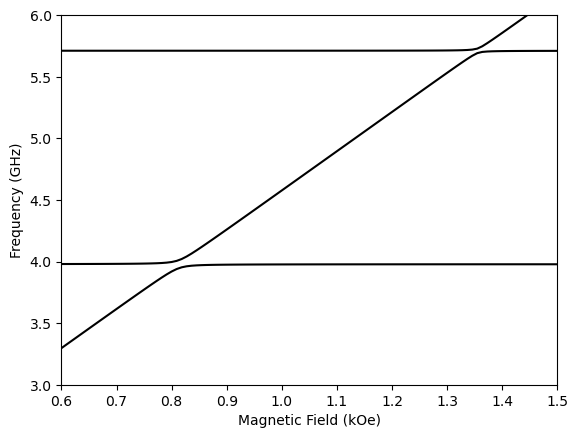

In [28]:
#Numerical calculations of dispersion spectra for case-1 (J > Γ)
θ = 0
γ1n=0.0001; γ2n=0.008*sin(θ)^2; γ3n=0.02*cos(θ)^2

gn1=0.038; gn2=0.033; gn3=0.02;
ω2n = 3.9790176; ω3n = 5.71;
Hlist = range(0.60, 1.5, length=100) |> collect
occupationList1 = Float64[]; occupationList2 = Any[]; occupationList3 = Any[]
for H in Hlist
        substitutions = Dict(ω1=>1.38284384+(3.19289744)*H,ω2=>ω2n,ω3=>ω3n,g1=>gn1,g2=>gn2,g3=>gn3,γ1=>γ1n,γ2=>γ2n,γ3=>γ3n)
        An=substitute( A, substitutions)
        Ann = 1im*zeros(3,3)  #create a zeros(matrix) of 3*3
        
        for i=1:3
            for j=1:3
                Ann[i,j] = real(An[i,j]).val + 1im * imag(An[i,j]).val
            end
        
        end
        if abs(H-0.8) < 1e-2
            println(1im*Ann)
        end
        data0=Ann * 1im
        data1 = la.eigen(data0) #Use the eigen function to compute the eigenvalues and eigenvectors of data0.
    
        datar=la.real(data1.values) #Extract the real part of eigenvalues from the result and print them, eigenvalues = data1.values,eigenvectors = data1.vectors
        r1n=datar[1]; r2n=datar[2];  r3n=datar[3];
        #print(datar)
    push!(occupationList1, r1n); push!(occupationList2, r2n); push!(occupationList3, r3n) # Add a floating-point number to occupationList1,Add different types of elements to occupationList2
end

using PyPlot
plot(Hlist,occupationList1,"k");plot(Hlist,occupationList2,"k"); plot(Hlist,occupationList3,"k")
xlabel("Magnetic Field (kOe)"); ylabel("Frequency (GHz)")

xlim(0.6, 1.5)
ylim(3, 6) 
savefig("Example1.png")


ComplexF64[3.9081354516363636 - 0.0001im 0.033 - 0.0008944271909999159im 0.058 + 0.0im; 0.033 - 0.0008944271909999159im 3.9790176 - 0.008im 0.038 + 0.0im; 0.058 + 0.0im 0.038 + 0.0im 5.71 + 0.0im]
ComplexF64[3.937161792 - 0.0001im 0.033 - 0.0008944271909999159im 0.058 + 0.0im; 0.033 - 0.0008944271909999159im 3.9790176 - 0.008im 0.038 + 0.0im; 0.058 + 0.0im 0.038 + 0.0im 5.71 + 0.0im]
ComplexF64[3.9661881323636363 - 0.0001im 0.033 - 0.0008944271909999159im 0.058 + 0.0im; 0.033 - 0.0008944271909999159im 3.9790176 - 0.008im 0.038 + 0.0im; 0.058 + 0.0im 0.038 + 0.0im 5.71 + 0.0im]


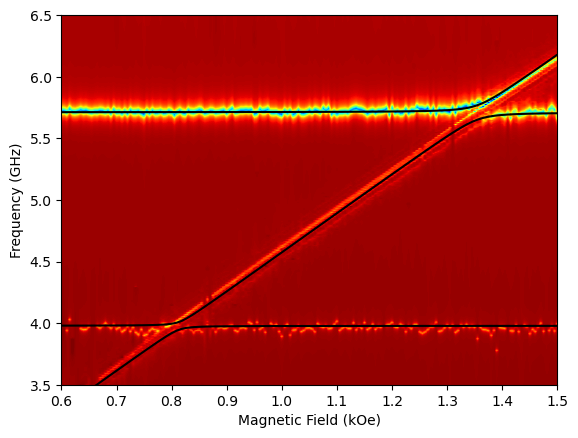

In [31]:
#Numerical calculations of dispersion spectra for case-1 (J > Γ)
θ = 0
γ1n=0.0001; γ2n=0.008*cos(θ)^2; γ3n=0.02*sin(θ)^2

gn1=0.038; gn2=0.033; gn3=0.058;
ω2n = 3.9790176; ω3n = 5.71;
Hlist = range(0.60, 1.5, length=100) |> collect
occupationList1 = Float64[]; occupationList2 = Any[]; occupationList3 = Any[]
for H in Hlist
        substitutions = Dict(ω1=>1.38284384+(3.19289744)*H,ω2=>ω2n,ω3=>ω3n,g1=>gn1,g2=>gn2,g3=>gn3,γ1=>γ1n,γ2=>γ2n,γ3=>γ3n)
        An=substitute( A, substitutions)
        Ann = 1im*zeros(3,3)  #create a zeros(matrix) of 3*3
        
        for i=1:3
            for j=1:3
                Ann[i,j] = real(An[i,j]).val + 1im * imag(An[i,j]).val
            end
        
        end
        if abs(H-0.8) < 1e-2
            println(1im*Ann)
        end
        data0=Ann * 1im
        data1 = la.eigen(data0) #Use the eigen function to compute the eigenvalues and eigenvectors of data0.
    
        datar=la.real(data1.values) #Extract the real part of eigenvalues from the result and print them, eigenvalues = data1.values,eigenvectors = data1.vectors
        r1n=datar[1]; r2n=datar[2];  r3n=datar[3];
        #print(datar)
    push!(occupationList1, r1n); push!(occupationList2, r2n); push!(occupationList3, r3n) # Add a floating-point number to occupationList1,Add different types of elements to occupationList2
end

using PyPlot
plot(Hlist,occupationList1,"k",linewidth=1.5);plot(Hlist,occupationList2,"k",linewidth=1.5); plot(Hlist,occupationList3,"k",linewidth=1.5)
xlabel("Magnetic Field (kOe)"); ylabel("Frequency (GHz)")

xlim(0.6, 1.5)
ylim(3.5, 6.5) 
savefig("Example1.png")

using DelimitedFiles
file_path = raw"E:\Abhishek\Paper writting\paper_3_elc rotation\Simulation Data\Rotation run files\result text file\csv files for julia fitting\srr.ring.60.600.5.1500.csv"

data = readdlm(file_path, ',', Float64, '\n')
# Convert the DataFrame to a Julia matrix
s = Matrix(data)

i1 = 600
i2 = 1500
t1 = 5
l1 = 3
l2 = 7
t2 = 0.0013333

x = i1:t1:i2
y = l1:t2:l2  # Adjusted to ensure it covers the range [3, 5)

# Plot using 'jet' colormap and adjust colorbar scale
#heatmap(x, y, s, c=:jet, clim=(-7, 0),
#        xlabel="X-axis", ylabel="Y-axis", title="Contour Plot with Jet Colormap")

#pcolormesh(x/1000,y,s,cmap="jet",clim=(-7,0),levels=-7:0.1:0)
contourf(x/1000, y, s, cmap="jet", levels=-7:0.01:0)
#plot(Hlist,occupationList1,"k",linewidth=2);plot(Hlist,occupationList2,"k",linewidth=2); plot(Hlist,occupationList3,"k",linewidth=2)
# Set custom y-axis range
#yaxis!((3.6, 4.4))
#ylim(3.6,4.4)
# Save the figure with higher resolution (e.g., 300 dpi)
savefig("Example1.png")

#@show pwd()
#display("image/png", read("Example.png"))
#println("Size of x: ", size(x))
#println("Size of y: ", size(y))
#println("Size of s: ", size(s))